<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB
None
       hours_studied  sleep_hours  attendance_percent  previous_scores  \
count     200.000000   200.000000          200.000000       200.000000   
mean        6.305000     6.598500           74.809000        66.500000   
std         3.228045     1.503178           14.768975        15.887481   
min         1.000000     3.800000           47.900000        37.000000   
25%         3.600000     5.300000           61.925000        54.000

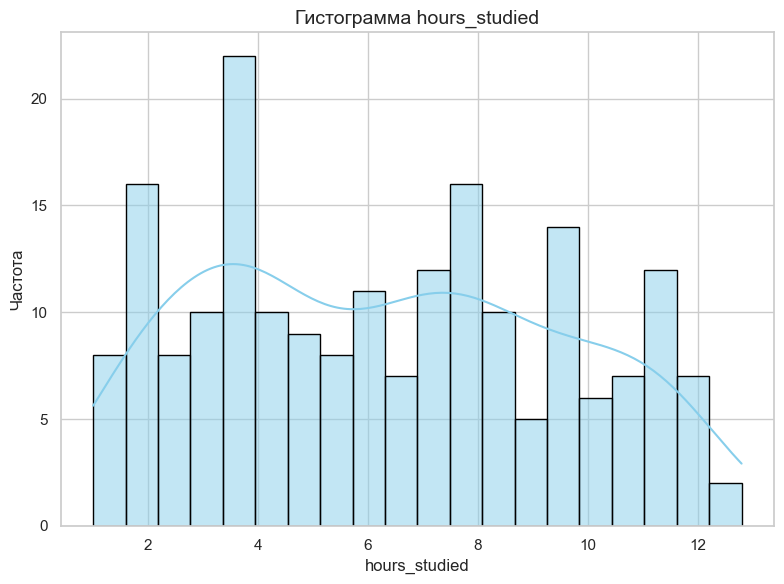

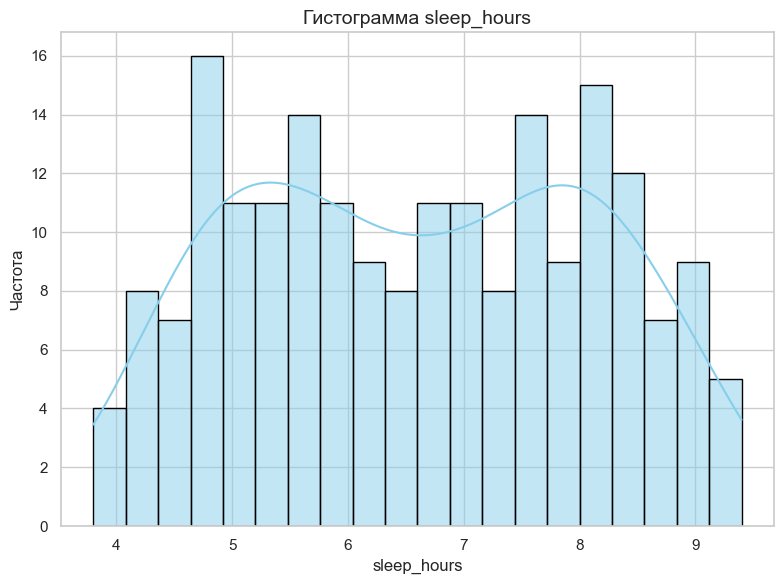

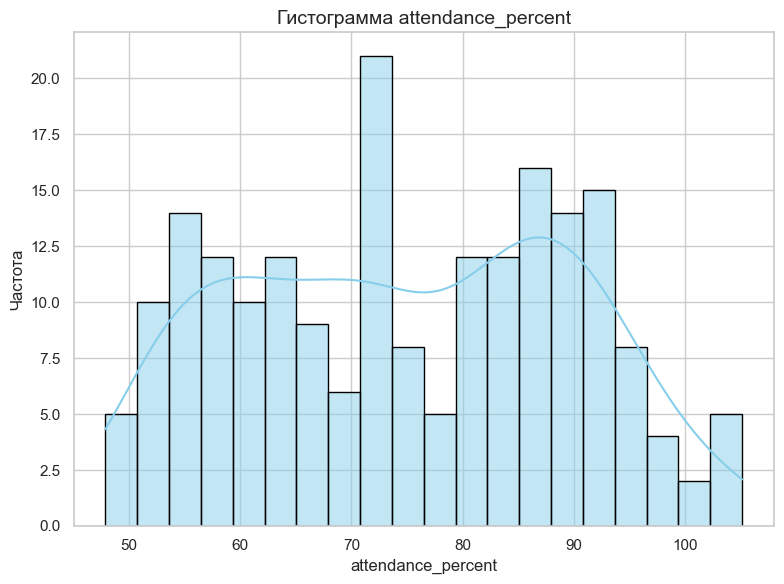

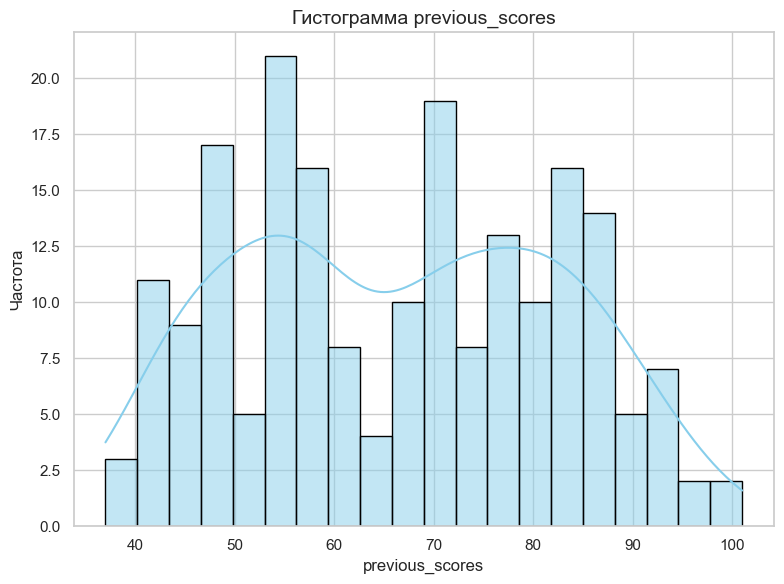

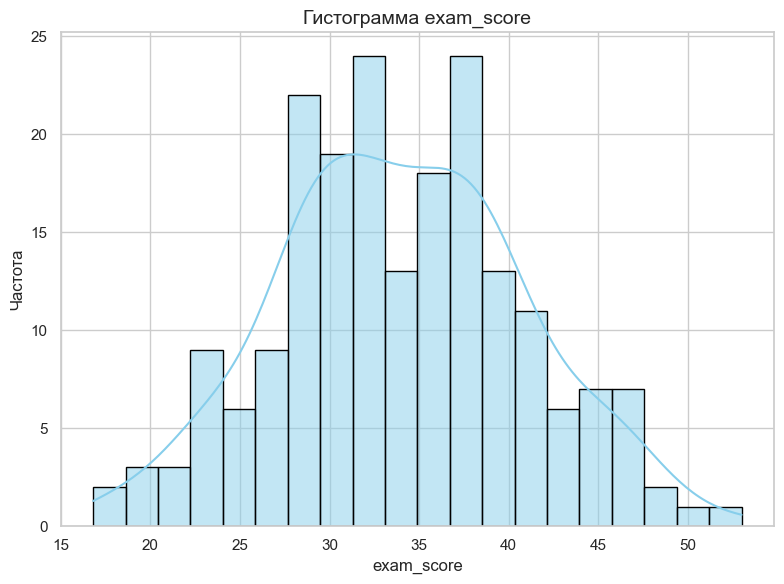

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv('student_exam_scores_modified.csv')
os.makedirs("plots", exist_ok=True)

print(df.info())
print(df.describe())

sns.set(style="whitegrid", palette="muted")
columns_to_plot = [col for col in df.columns if col != "student_id"]

for col in columns_to_plot:
    plt.figure(figsize=(8, 6))
    if df[col].dtype == "object" or df[col].nunique() <= 4:
        sns.countplot(data=df, x=col)
        plt.title(f"Распределение {col}", fontsize=14)
        plt.xlabel(col)
        plt.ylabel("Количество")
    else:
        sns.histplot(df[col], bins=20, kde=True, color="skyblue", edgecolor="black")
        plt.title(f"Гистограмма {col}", fontsize=14)
        plt.xlabel(col)
        plt.ylabel("Частота")
    plt.tight_layout()
    plt.savefig(f"plots/{col}_distribution.png", dpi=300)
    plt.show()

Гистограмма hours_studied показывает, что распределение количества часов, затраченных на подготовку, близко к равномерному — заметны колебания без выраженного пика.
Гистограмма exam_score и attendance_percent отдалённо напоминает нормальное распределение с несколькими локальными максимумами.
Гистограмма previous_scores и sleep_hours напоминают бимодальное распределение, выраженны два пика.

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('student_exam_scores.csv')
df = df[df['hours_studied'] > 0]
dfs = df.copy()
num_cols = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']

if 'student_id' in dfs.columns:
    dfs = dfs.drop(columns=['student_id'])

scaler = StandardScaler()
dfs[num_cols] = scaler.fit_transform(dfs[num_cols])
print(dfs.head())

dfs.to_csv('preprocessed_student_exam_scores.csv', index=False)

   hours_studied  sleep_hours  attendance_percent  previous_scores  exam_score
0       0.520154     1.458426           -0.192061        -1.395230        30.2
1      -1.561083     1.324503           -0.994074        -0.755216        25.0
2      -0.722376     1.056656           -0.079498         1.228827        35.8
3      -0.877692    -1.220042            1.426035        -0.051201        34.0
4       0.861850    -0.148655            1.053170         0.268806        40.3


Убираем выбросы и некорректные значения.
Нормализуем числовые признаки при помощи StandardScaler, чтобы привести их к единому масштабу со средним 0 и стандартным отклонением 1.

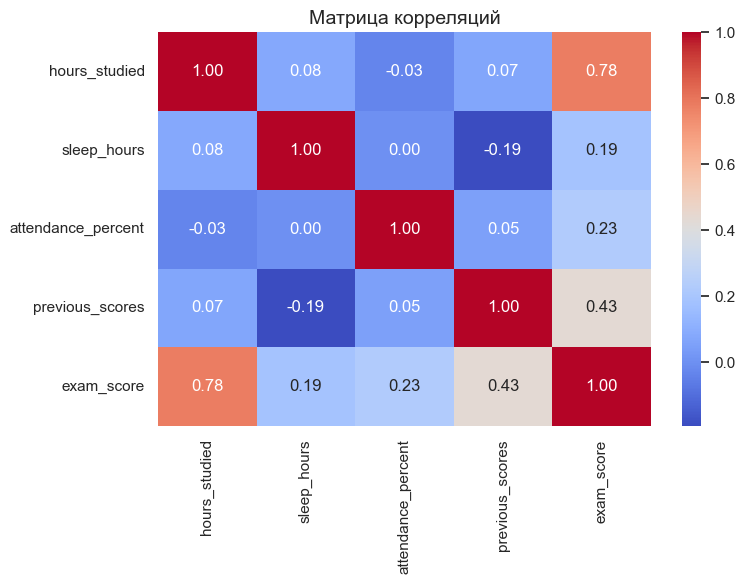

In [24]:
numeric_cols = df.select_dtypes(include='number').columns.drop('student_id', errors='ignore')

plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций', fontsize=14)
plt.tight_layout()
plt.savefig('plots/correlation_matrix.png', dpi=300)
plt.show()

Наблюдается выраженная корреляция между следующими параметрами:
— Часами подготовки и результатом экзамена,
— Предыдущими оценками и результатом экзамена,
— Посещаемостью и результатом экзамена.
Также заметна слабая или отсутствующая связь между другими характеристиками, например — количеством часов сна, посещаемостью и временем, затраченным на учебу.


In [25]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = pd.read_csv('student_exam_scores_modified.csv')
X = df.drop(columns=['exam_score', 'student_id'])
X_const = add_constant(X)


vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

              Feature        VIF
0               const  71.067556
1       hours_studied   1.014072
2         sleep_hours   1.049255
3  attendance_percent   1.003324
4     previous_scores   1.042986


VIF показывает, насколько сильно один независимая переменная коррелирует с другими.
Все числовые признаки (hours_studied, sleep_hours, attendance_percent, previous_scores) имеют низкую мультиколлинеарность (VIF ≈ 1), что говорит о слабой корреляции между ними.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

df = pd.read_csv('student_exam_scores.csv')
df = df.drop(columns=['student_id'])  # исключаем ID
X = df[['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']]
y = df['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)

print("    Линейная регрессия    ")
print(f"RMSE: {rmse_lin:.2f}")
print(f"R²: {r2_lin:.3f}")
print(f"MAPE: {mape_lin:.3%}")

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)

print("\n    Гребневая регрессия    ")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"R²: {r2_ridge:.3f}")
print(f"MAPE: {mape_ridge:.3%}")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lin = cross_val_score(lin_model, X, y, cv=kf, scoring='r2')
cv_scores_ridge = cross_val_score(ridge_model, X, y, cv=kf, scoring='r2')

print("\n    Кросс-валидация (R²)   ")
print(f"Линейная: {cv_scores_lin.mean():.3f} ± {cv_scores_lin.std():.3f}")
print(f"Гребневая: {cv_scores_ridge.mean():.3f} ± {cv_scores_ridge.std():.3f}")

    Линейная регрессия    
RMSE: 2.79
R²: 0.854
MAPE: 6.968%

    Гребневая регрессия    
RMSE: 2.79
R²: 0.854
MAPE: 6.971%

    Кросс-валидация (R²)   
Линейная: 0.834 ± 0.023
Гребневая: 0.834 ± 0.023


На основании проведённого анализа можно отметить, что результаты линейной и гребневой регрессии оказались практически идентичными. Оба метода демонстрируют одинаковое значение коэффициента детерминации (R² = 0.854), что свидетельствует о высоком уровне объясняющей способности моделей — около 85% вариации итоговых экзаменационных баллов объясняется выбранными признаками.
Среднеквадратичная ошибка (RMSE = 2.79) и средняя абсолютная процентная ошибка (MAPE ≈ 6.97%) также указывают на высокую точность прогнозирования и минимальные отклонения от реальных значений.
Результаты кросс-валидации подтверждают устойчивость моделей: среднее значение R² составляет 0.834 с незначительным стандартным отклонением (±0.023), что говорит о стабильности качества при разделении данных.


Количество главных компонент: 4


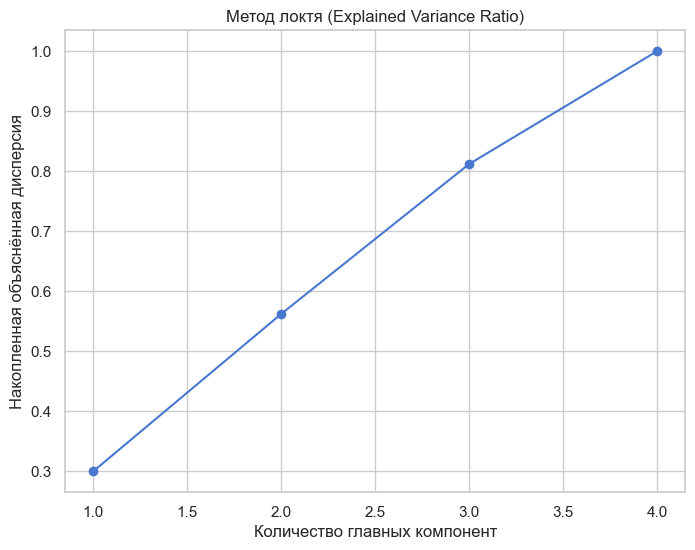

1 компонент: 0.300
2 компонент: 0.562
3 компонент: 0.812
4 компонент: 1.000

Матрица весов признаков (Loadings):
                      PC1    PC2    PC3    PC4
hours_studied      -0.058  0.900  0.166 -0.399
sleep_hours        -0.692  0.177  0.309  0.628
attendance_percent  0.186 -0.242  0.934 -0.186
previous_scores     0.695  0.316  0.071  0.642

    PCA    
Линейная: RMSE=2.79, R²=0.854, MAPE=6.968%
Гребневая: RMSE=2.79, R²=0.854, MAPE=6.978%


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('student_exam_scores.csv')
df = df.drop(columns=['student_id'])

X = df[['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']]
y = df['exam_score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)
print("\nКоличество главных компонент:", X_pca.shape[1])

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

pca_full = PCA()
pca_full.fit(X_scaled)

explained_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel("Количество главных компонент")
plt.ylabel("Накопленная объяснённая дисперсия")
plt.title("Метод локтя (Explained Variance Ratio)")
plt.grid(True)
plt.show()

for i, val in enumerate(explained_var, start=1):
    print(f"{i} компонент: {val:.3f}")

# Матрица весов признаков
loadings = pd.DataFrame(
    pca_full.components_.T,
    columns=[f"PC{i+1}" for i in range(pca_full.n_components_)],
    index=X.columns
)
print("\nМатрица весов признаков (Loadings):")
print(loadings.round(3))

lin_pca = LinearRegression().fit(X_train_pca, y_train)
y_pred_lin_pca = lin_pca.predict(X_test_pca)
rmse_lin_pca = np.sqrt(mean_squared_error(y_test, y_pred_lin_pca))
r2_lin_pca = r2_score(y_test, y_pred_lin_pca)
mape_lin_pca = mean_absolute_percentage_error(y_test, y_pred_lin_pca)

ridge_pca = Ridge(alpha=1.0).fit(X_train_pca, y_train)
y_pred_ridge_pca = ridge_pca.predict(X_test_pca)
rmse_ridge_pca = np.sqrt(mean_squared_error(y_test, y_pred_ridge_pca))
r2_ridge_pca = r2_score(y_test, y_pred_ridge_pca)
mape_ridge_pca = mean_absolute_percentage_error(y_test, y_pred_ridge_pca)

print("\n    PCA    ")
print(f"Линейная: RMSE={rmse_lin_pca:.2f}, R²={r2_lin_pca:.3f}, MAPE={mape_lin_pca:.3%}")
print(f"Гребневая: RMSE={rmse_ridge_pca:.2f}, R²={r2_ridge_pca:.3f}, MAPE={mape_ridge_pca:.3%}")

После применения PCA три главные компоненты объясняют более 80% дисперсии, а все четыре — полностью.
Наибольший вклад в компоненты вносят hours_studied, sleep_hours, attendance_percent и previous_scores.
Регрессионные модели на PCA-признаках показали высокое качество предсказания: R² ≈ 0.85, RMSE ≈ 2.79, MAPE ≈ 7%.
Таким образом, PCA успешно снизил размерность признаков и устранил мультиколлинеарность без потери информативности.

In [17]:

comparison = pd.DataFrame({
    "Модель": ["Линейная (исходные)", "Гребневая (исходные)",
               "Линейная (PCA)", "Гребневая (PCA)"],
    "RMSE": [rmse_lin, rmse_ridge, rmse_lin_pca, rmse_ridge_pca],
    "R²": [r2_lin, r2_ridge, r2_lin_pca, r2_ridge_pca],
    "MAPE": [mape_lin, mape_ridge, mape_lin_pca, mape_ridge_pca]
})
print("\n   Сравнение метрик   ")
print(comparison)


   Сравнение метрик   
                 Модель      RMSE        R²      MAPE
0   Линейная (исходные)  2.785998  0.853745  0.069676
1  Гребневая (исходные)  2.786788  0.853662  0.069709
2        Линейная (PCA)  2.785998  0.853745  0.069676
3       Гребневая (PCA)  2.785854  0.853760  0.069777


Таким образом, использование метода главных компонентов позволило сохранить качество моделей практически на том же уровне по сравнению с исходными признаками. После снижения размерности R² остался примерно на уровне 0,854, RMSE почти не изменился (≈2,78), а MAPE изменился минимально (≈6,97%). Также стоит отметить, что различия между линейной и гребневой моделями после PCA остаются крайне незначительными, как и для исходных данных.

Вывод: использование метода главных компонент позволило устранить возможную мультиколлинеарность и снизить размерность признаков без потери значимой информации, при этом модели сохраняют высокую точность предсказаний